In [1]:
import pyreadstat
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import functions

colors_2 = ["#4096E6", "#40E6DD"]
colors_3 = ["#4096E6", "#53D8FC", "#40E6DD"]
colors_4 = ["#4776FE", "#4096E6", "#40E6DD", "#47FEC1"]
colors_5 = ["#4776FE", "#4096E6", "#53D8FC", "#40E6DD", "#47FEC1"]

In [2]:
sns.set_context('talk')

# Read in Data

In [3]:
file = "../data/processed_data.sav"
data, metadata = pyreadstat.read_sav(file)

In [6]:
# the science-based survey questions for the cluster analysis
cluster_feats = ['q5_rec', 'q9a_rec', 'q11a_rec', 'q11b_rec', 'q11c_rec', 'q12a_rec', 'q12b_rec', 'q12c_rec', 
                 'q15_rec', 'q16a_rec', 'q16b_rec', 'q18_rec', 'q19_rec', 'q20_rec', 'q23a_rec', 'q23b_rec', 
                 'q23c_rec', 'q29_rec', 'q33_rec', 'q36_rec', 'q37_rec']

cluster_feature_descriptions = {
    'q5_rec': "Developments in science have mostly positive effect on society",
    'q9a_rec': "Investment in scientific research is worthwhile",
    'q11a_rec': "Job automation is good for society",
    'q11b_rec': "Development of AI is good for society",
    'q11c_rec': "Government space program is good for society",
    'q12a_rec': "Gene editing is appropriate use of technology",
    'q12b_rec': "Animal cloning is appropriate use of technology",
    'q12c_rec': "Fertility is appropriate use of technology",
    'q15_rec': "Scientists make fact-based judgments",
    'q16a_rec': "MMR vaccine has high risk of side effects",
    'q16b_rec': "MMR vaccine has high preventative health benefits",
    'q18_rec': "Safe to consume pesticides",
    'q19_rec': "Safe to consume preservatives",
    'q20_rec': "Safe to consume GMOs",
    'q23a_rec': "Modifying genetics at infancy to boost intelligence is appropriate",
    'q23b_rec': "Modifying genetics at infancy to reduce risk of disease is appropriate",
    'q23c_rec': "Modifying genetics at infancy to treat disease is appropriate",
    'q29_rec': "Human activity contributes to climate change",
    "q33_rec": "Science and religion conflict", 
    'q36_rec': "Believes in evolution",
    'q37_rec': "Science and religion are compatible on origins of life"
}

In [8]:
# survey question columns - non-science
survey_feats = ['q1_rec', 'q2a_rec', 'q2b_rec', 'q2c_rec', 'q2d_rec', 'q2e_rec', 'q4a_rec', 'q4b_rec', 'q4c_rec', 
                'q4d_rec', 'q4e_rec', 'q4f_rec', 'q4g_rec', 'q4h_rec', 'q7_rec',
                'q24a_rec', 'q24b_rec', 'q24c_rec', 'q24e_rec', 'q24f_rec', 'q25_rec', 'q26a_rec', 'q26b_rec', 
                'q26c_rec', 'q26d_rec', 'q26e_rec', 'q26f_rec', 'q26g_rec', 'q27_rec', 'q28_rec', 'q30_rec', 
                'q31_rec', 'q32_rec', 'q34_rec',  'q39_rec', 'q40_rec', 'q41a_rec', 'q41b_rec', 'q41c_rec',
                'q42_rec', 'q43_rec']
survey_feature_descriptions = {
    "q1_rec": "Satisfied with the way things are going in country",
    "q2a_rec": "Trust national government to do right for country",
    "q2b_rec": "Trust military to do right for country",
    "q2c_rec": "Trust news media to do right for country",
    "q2d_rec": "Trust scientists to do right for country",
    "q2e_rec": "Trust business leaders to do right for country",
    "q4a_rec": "Country above average in its scientific achievements",
    "q4b_rec": "Country above average in its political system",
    "q4c_rec": "Country above average in its economy",
    "q4d_rec": "Country above average in its military",
    "q4e_rec": "Country above average in its k-12 STEM education",
    "q4f_rec": "Country above average in its medical treatments",
    "q4g_rec": "Country above average in its technologica achievements",
    "q4h_rec": "Country above average in its post-secondary STEM education",
    "q7_rec": "Important for country to be scientific leader",
    "q24a_rec": "Air pollution is problem for country",
    "q24b_rec": "Pollution of rivers, lakes, oceans is problem for country",
    "q24c_rec": "Extinction of species is problem for country",
    "q24e_rec": "Waste and landfills is a problem in country",
    "q24f_rec": "Deforestation is a problem in country",
    "q25_rec": "Protect environment even if it hurts economy",
    "q26a_rec": "Favor more solar as energy source",
    "q26b_rec": "Favor more wind as energy source",
    "q26c_rec": "Favor more coal as energy source",
    "q26d_rec": "Favor more natural gas as energy source",
    "q26e_rec": "Favor more nuclear power as energy source",
    "q26f_rec": "Favor more oil as energy source",
    "q26g_rec": "Favor more hydropower as energy source",
    "q27_rec": "Increase production renewable energy",
    "q28_rec": "Climate change is a problem",
    "q30_rec": "National government not doing enough to address climate change",
    "q31_rec": "Climate change is affecting local community",
    "q32_rec": "Religion is important in life",
    "q34_rec": "Personal religious beliefs conflict with science often",  
    "q39_rec": "Consume news about science often", 
    "q40_rec": "News media covers science well", 
    "q41a_rec": "Public doesn't know enough about science, is a problem", 
    "q41b_rec": "Media oversimplifies scientific research, is a problem", 
    "q41c_rec": "Scientists overstate their findings, is a problem",
    "q42_rec": "Country can find ways to solve problems", 
    "q43_rec": "Rely on experts over practitioners to solve problems"
}

In [10]:
demo_feats = ['is_female', 'age_rec', 'educ_rec',
       'ideo_rec', 'sc_bin', 'sc_count', 'is_christian', 'is_protestant',
       'is_catholic', 'is_ath_ag', 'attend_rec', 'pray_rec', 'is_white',
       'is_black', 'is_hisp', 'pid_rec', 'is_genz', 'is_millennial', 'is_genx',
       'is_boomer', 'is_silent', 'hh_rec']

In [11]:
# dictionary for column name: question wording
wording_dict = dict(zip(metadata.column_names, metadata.column_labels))

In [12]:
# nested dictionary for column name: response labels
response_dict = metadata.variable_value_labels

# Factor Analysis

In [13]:
Q = data[survey_feats]
wt = data['weight']

In [14]:
# pretest on features to determine appropriateness of factor analysis
chi_square_value,p_value=calculate_bartlett_sphericity(Q)
chi_square_value, p_value

(21699.727369389027, 0.0)

In [15]:
# second test to determine appropriateness of factor analysis
kmo_all,kmo_model=calculate_kmo(Q)
kmo_model

/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.9356306003596205

In [16]:
# Create factor analysis object and fit factor analysis model
fa_q = FactorAnalyzer(n_factors = Q.shape[1], rotation=None)
fa_q.fit(Q)

# Get Eigenvalues
ev_q, v_q = fa_q.get_eigenvalues()

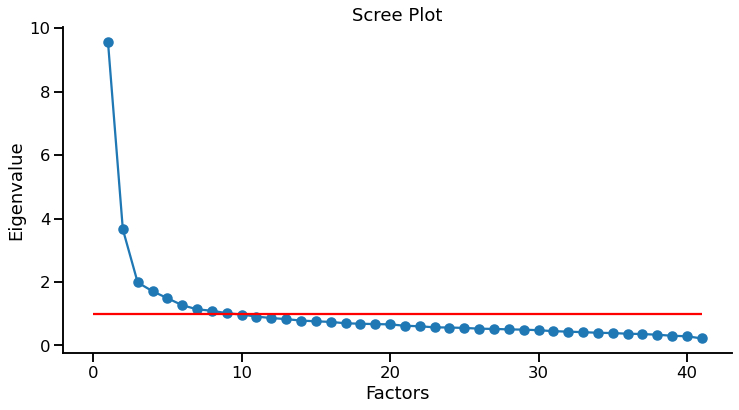

In [13]:
# Create scree plot using matplotlib
plt.figure(figsize = (12,6))
plt.scatter(range(1, Q.shape[1]+1), ev_q)
plt.plot(range(1, Q.shape[1]+1), ev_q)
plt.hlines(1, xmin = 0, xmax = Q.shape[1], color = 'red')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
sns.despine()
plt.savefig("../images/scree_qs.png", dpi = 300, bbox_inches = 'tight');

In [17]:
# Instantiate factor analysis object and fit the model
q_factor_cols = ["QFactor_1", "QFactor_2", "QFactor_3", "QFactor_4", "QFactor_5", "QFactor_6", "QFactor_7",
            "QFactor_8", "QFactor_9"]
fa_q = FactorAnalyzer(n_factors = 9, rotation = "varimax")
fa_q.fit(Q)

# save factor loadings to dataframe 
q_loadings = pd.DataFrame(fa_q.loadings_, 
                        index = Q.columns, 
                        columns = q_factor_cols)

# save factor values as dataframe
q_factors = pd.DataFrame(fa_q.transform(Q), 
                         index = Q.index, 
                         columns = q_factor_cols)

# join factor values to main dataframe
data = data.join(q_factors)

# Get factor variances
q_factor_var = pd.DataFrame(fa_q.get_factor_variance(),
                            index = ['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                            columns = q_factor_cols)

In [18]:
q_factor_var

,QFactor_1,QFactor_2,QFactor_3,QFactor_4,QFactor_5,QFactor_6,QFactor_7,QFactor_8,QFactor_9
SS Loadings,4.496736,3.363126,2.472772,2.224432,1.292412,1.086110,1.069224,0.977135,0.908578
Proportion Var,0.109676,0.082027,0.060312,0.054254,0.031522,0.026490,0.026079,0.023833,0.022160
Cumulative Var,0.109676,0.191704,0.252015,0.306270,0.337792,0.364283,0.390361,0.414194,0.436354


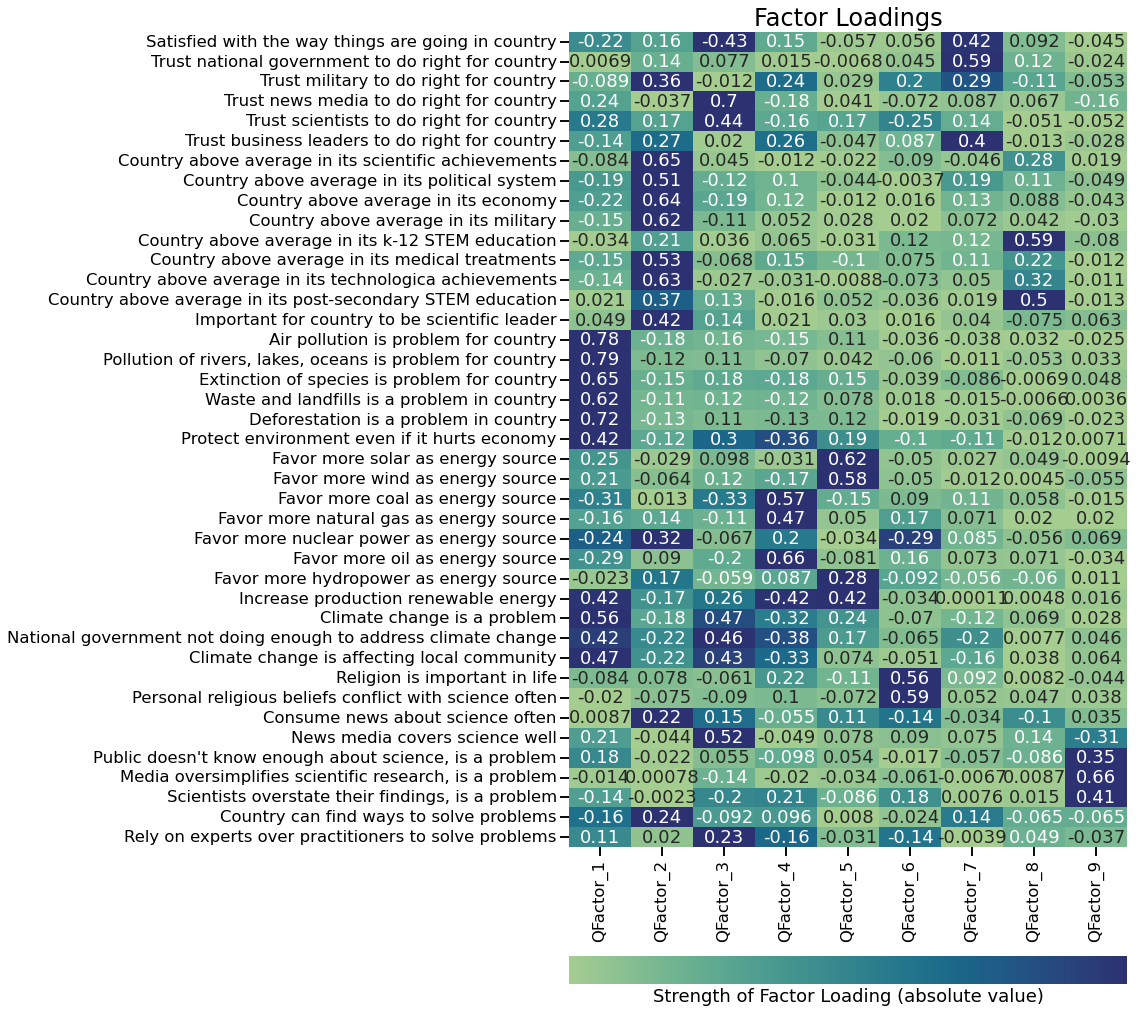

In [16]:
# make heatmap of the factor loadings for each variable used in the cluster model

# normalizes averages by row - for color formatting the heatmap
# each row represents one of the variables in the clustering model
# set up empty list
tmp_array = []

# loop through each row of cluster averages to create embedded array of averages normalized by row
for row in q_loadings.index:
    tmp_min = np.abs(q_loadings.loc[row]).min() # obtain the minimum for that row
    tmp_max = np.abs(q_loadings.loc[row]).max() # obtain the maximum for that row

    # normalizes each average in a row based on that row's min and max
    tmp_array.append([(np.abs(x)-tmp_min)/(tmp_max-tmp_min) for x in q_loadings.loc[row]])

# save normalized averages to dataframe
norm_df = pd.DataFrame(tmp_array, index = q_loadings.index, columns = q_loadings.columns)

# generate heatmap
plt.figure(figsize = (10,20))
sns.heatmap(norm_df, annot = q_loadings, yticklabels = q_loadings.index.map(survey_feature_descriptions), 
            cmap = "crest",
            cbar_kws = {'label': 'Strength of Factor Loading (absolute value)', 'ticks': [], 
                        'orientation': 'horizontal', 'pad': 0.1})
plt.title("Factor Loadings", fontsize = 24)
plt.savefig("../images/factor_qs.png", dpi = 300, bbox_inches = 'tight');

In [19]:
q_factor_vars = {
    'QFactor_1': ['q24a_rec', 'q24b_rec', 'q24c_rec', 'q24e_rec', 'q24f_rec', 'q25_rec', 'q27_rec', 'q28_rec',
                  'q30_rec', 'q31_rec'],
    'QFactor_2': ['q2b_rec', 'q4a_rec', 'q4b_rec', 'q4c_rec', 'q4d_rec', 'q4f_rec', 'q4g_rec', 'q7_rec', 'q26e_rec',
                  'q39_rec', 'q42_rec'],
    'QFactor_3': ['q1_rec', 'q2c_rec', 'q2d_rec', 'q28_rec', 'q30_rec', 'q31_rec', 'q40_rec', 'q43_rec'],
    'QFactor_4': ['q26c_rec', 'q26d_rec', 'q26f_rec', 'q27_rec'],
    'QFactor_5': ['q26a_rec', 'q26b_rec', 'q26g_rec', 'q27_rec'],
    'QFactor_6': ['q26e_rec', 'q32_rec', 'q34_rec'],
    'QFactor_7': ['q1_rec', 'q2a_rec'],
    'QFactor_8': ['q4e_rec', 'q4h_rec'],
    'QFactor_9': ['q41a_rec', 'q41b_rec', 'q41c_rec']
}

In [20]:
# labels for the factors
q_factor_descriptions = {"QFactor_1": "Environmental issues", 
                         "QFactor_2": "Patriotic sentiment", 
                         "QFactor_3": "Dissatisfaction but trust in media, experts", 
                         "QFactor_4": "Favor fossil fuels not renewable energy sources", 
                         "QFactor_5": "Favor renewable energy sources",
                         "QFactor_6": "Religion is important and conflicts with science",
                         "QFactor_7": "Satisfied and trust government, business",
                         "QFactor_8": "Postive about STEM education in country",
                         "QFactor_9": "Science knowledge, reporting not good enough"}

# Cluster Analysis

### KMeans

In [21]:
X = data[cluster_feats]
wt = data['weight']

In [22]:
# loop to run kmeans with different numbers of clusters for comparison
inertia_list = []
silhouette_list = []
clusters_dict = {}
for n_clust in range(2,21):
    kmeans = KMeans(n_clusters = n_clust, init = 'k-means++', random_state = 42)
    kmeans.fit(X, sample_weight = wt)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X, kmeans.labels_, random_state = 42))
    clusters_dict[n_clust] = kmeans.labels_

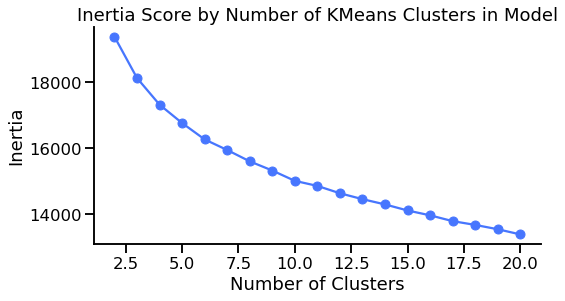

In [21]:
# idea for this inertia plot from analytics vidhya
# https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
plt.figure(figsize = (8,4))
plt.plot(range(2,21), inertia_list, marker = 'o', color = colors_5[0])
plt.title("Inertia Score by Number of KMeans Clusters in Model")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
sns.despine()
plt.savefig("../images/kmeans_inertia.png", dpi = 300, bbox_inches = 'tight');

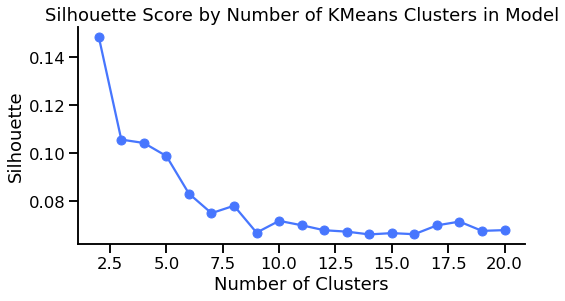

In [22]:
plt.figure(figsize = (8,4))
plt.plot(range(2,21), silhouette_list, marker = 'o', color = colors_5[0])
plt.title("Silhouette Score by Number of KMeans Clusters in Model")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette")
sns.despine()
plt.savefig("../images/kmeans_silhouette.png", dpi = 300, bbox_inches = 'tight');

In [23]:
# save clusters to dataframe
data['kmeans_6'] = clusters_dict[6]
data['kmeans_7'] = clusters_dict[7]
data['kmeans_8'] = clusters_dict[8]
data['kmeans_9'] = clusters_dict[9]
data['kmeans_10'] = clusters_dict[10]

# update meta dict with question wording
wording_dict['kmeans_6'] = "clusters: k-means, 6 clusters"
wording_dict['kmeans_7'] = "clusters: k-means, 7 clusters"
wording_dict['kmeans_8'] = "clusters: k-means, 8 clusters"
wording_dict['kmeans_9'] = "clusters: k-means, 9 clusters"
wording_dict['kmeans_10'] = "clusters: k-means, 10 clusters"

# update labels dict with categories and labels
response_dict['kmeans_6'] = {0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4", 4: "cluster 5", 
                             5: "cluster 6"}
response_dict['kmeans_7'] = {0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4", 4: "cluster 5", 
                             5: "cluster 6", 6: "cluster 7"}
response_dict['kmeans_8'] = {0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4", 4: "cluster 5", 
                             5: "cluster 6", 6: "cluster 7", 7: "cluster 8"}
response_dict['kmeans_9'] = {0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4", 4: "cluster 5", 
                             5: "cluster 6", 6: "cluster 7", 7: "cluster 8", 8: "cluster 9"}
response_dict['kmeans_10'] = {0: "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4", 4: "cluster 5", 
                              5: "cluster 6", 6: "cluster 7", 7: "cluster 8", 8: "cluster 9", 9: "cluster 10"}

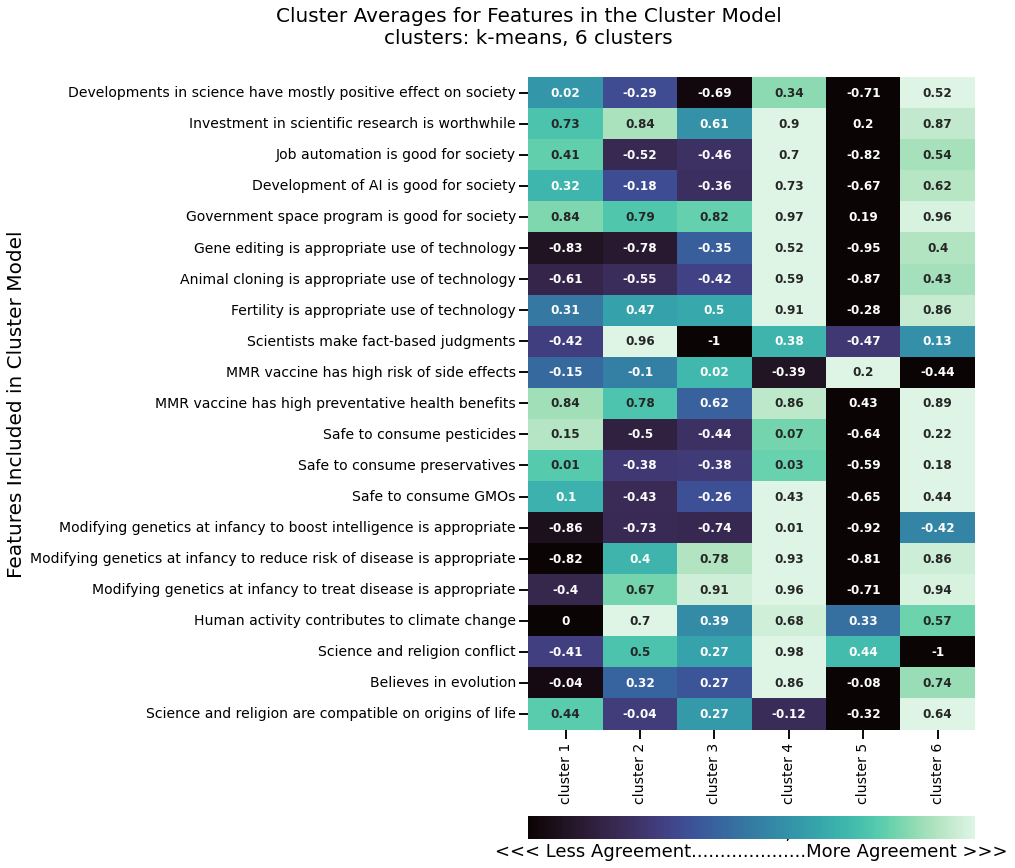

In [40]:
df = data 
w = 'weight' 
clust_vars = cluster_feats 
clust_col = 'kmeans_6'
resp = response_dict 
word = wording_dict 
feature_labels = cluster_feature_descriptions
figw=12 
figh=16

# set up empty dataframe
mean_df = pd.DataFrame(index = clust_vars)

# for loop goes through each cluster
for cluster in np.sort(df[clust_col].unique()):

    # filtering the data to the cluster of focus in the loop
    sub_df = df.loc[df[df[clust_col] == cluster].index, : ]

    # set up empty list to hold the averages
    mean_list = []

    # loop within loop - captures variable weighted averages for cluster of focus
    for var in clust_vars:
        mean_list.append(np.average(sub_df[var], weights = sub_df[w]))

    # saves weighted averages to dataframe
    #colname = f"cluster{cluster}"
    temp_ser = pd.Series(mean_list, index = clust_vars, name = resp[clust_col][cluster])
    mean_df = mean_df.join(temp_ser)

# normalizes averages by row - for color formatting the heatmap
# each row represents one of the variables in the clustering model
# set up empty list
tmp_array = []

# loop through each row of cluster averages to create embedded array of averages normalized by row
for row in mean_df.index:
    tmp_min = mean_df.loc[row].min() # obtain the minimum for that row
    tmp_max = mean_df.loc[row].max() # obtain the maximum for that row

    # normalizes each average in a row based on that row's min and max
    tmp_array.append([(x-tmp_min)/(tmp_max-tmp_min) for x in mean_df.loc[row]])

# save normalized averages to dataframe
norm_df = pd.DataFrame(tmp_array, index = clust_vars, columns = mean_df.columns)

# generate heatmap
# set figure size
plt.figure(figsize = (8,16))

# create heatmap
sns.heatmap(norm_df, # uses the dataframe of averages normalized by row min/max
            annot = round(mean_df, 2), # add data labels - uses the original dataframe of averages
            cmap = 'mako', # add color
            cbar = True, # add color bar legend
            annot_kws = {'fontsize': 12, 'weight': 'bold'}, # format data label font size and appearance
            cbar_kws = {'label': "<<< Less Agreement....................More Agreement >>>", # add label to color bar
                        'ticks': [], # remove ticks from color bar legend
                        'orientation': 'horizontal', # change color bar appearance from vertical to horizontal
                        'shrink': 1, # reduce size of color bar
                        'pad': 0.1}, # reduce padding between axis title and color bar
            yticklabels = norm_df.index.map(feature_labels))
#plt.tight_layout(rect = [0,0,1,1])
plt.title(f"Cluster Averages for Features in the Cluster Model\n{word[clust_col]}", fontsize = 20,
          pad = 50,
          ha = 'center', va = 'center', x = 0)
plt.xlabel(f"{word[clust_col]}", fontsize = 20, labelpad = 20)
plt.ylabel('Features Included in Cluster Model', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig("../images/cluster_hm.png", dpi = 300, bbox_inches = 'tight');

In [24]:
import textwrap

In [25]:
def bivar_ci(df, w, x, y, resp, word, figw = 12, figh = 6):
    """Bivariate bubble chart with confidence interval.

    Keyword arguments:
    df - the dataframe or subset
    w -- the name of the weight column
    x -- the 'row' variable
    y -- the 'column' variable (proportions will sum to 100 for each column)
    resp -- the dictionary containing the response codes and labels
    word -- the dictionary containing the column name and question wording
    figw -- width of figure (default 12)
    figh -- figure height (default 4)
    """
    prop, freq, ci = functions.bivar_table(df, w, x, y, resp)
    tab = ci.T
    if len(tab.columns) == 2:
        c = colors_2
    elif len(tab.columns) == 3:
        c = colors_3
    elif len(tab.columns) == 4:
        c = colors_4
    else:
        c = colors_5
    fig, ax = plt.subplots(figsize = (figw,figh))
    y_ax = list(range(len(tab.index)))
    ax.set_yticks(ticks = y_ax, labels = tab.index, fontsize = 14)
    ax.set_xlim(0, 1)
    for x_cat in list(range(len(tab.columns))):
        col = tab.columns[x_cat]
        x_ax = [x['Prop'] for x in tab[col]]
        xmin = [x['CI_lo'] for x in tab[col]]
        xmax = [x['CI_up'] for x in tab[col]]
        ax.scatter(x = x_ax, y = y_ax, s = 200, color = c[x_cat], label = col)
        ax.hlines(y = y_ax, xmin = xmin, xmax = xmax, color = c[x_cat], linewidth = 5)

    ax.legend(fontsize = 12, frameon = False, bbox_to_anchor = (0.5, 1.1), loc = "lower center")
    sns.despine()
    fig.tight_layout(rect = [0, 0, 1, 1])
    #fig.suptitle(f"{word[x]}", fontsize = 16, ha = 'center', va = 'bottom')
    fig.suptitle(textwrap.fill(word[x], 110) + "\n" + textwrap.fill(word[y], 50), fontsize = 16, ha = 'center', va = 'bottom')
    return plt.show();

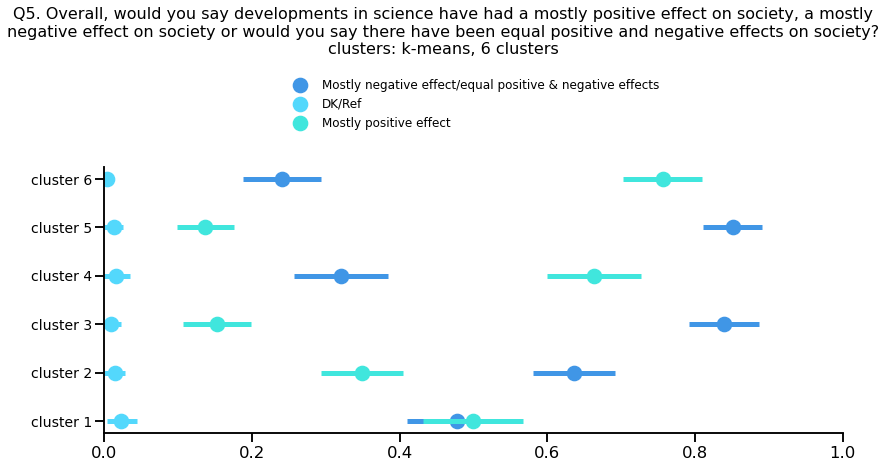

In [70]:
bivar_ci(data, 'weight', 'q5_rec', 'kmeans_6', response_dict, wording_dict)

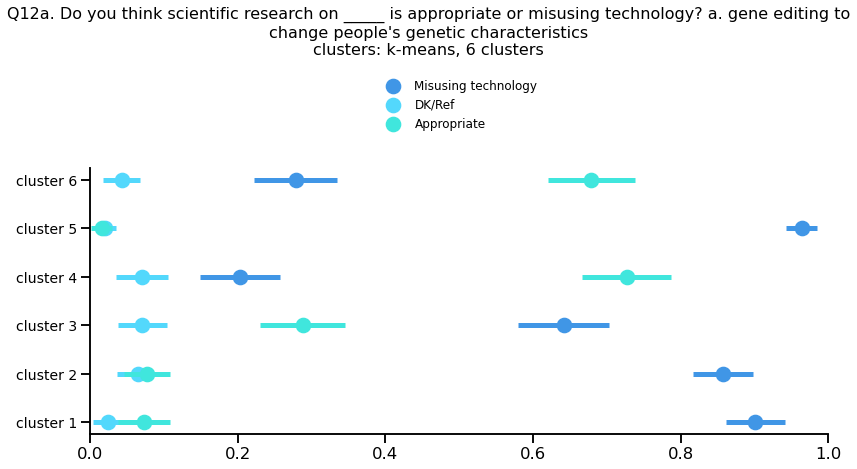

In [75]:
bivar_ci(data, 'weight', cluster_feats[5], 'kmeans_6', response_dict, wording_dict)

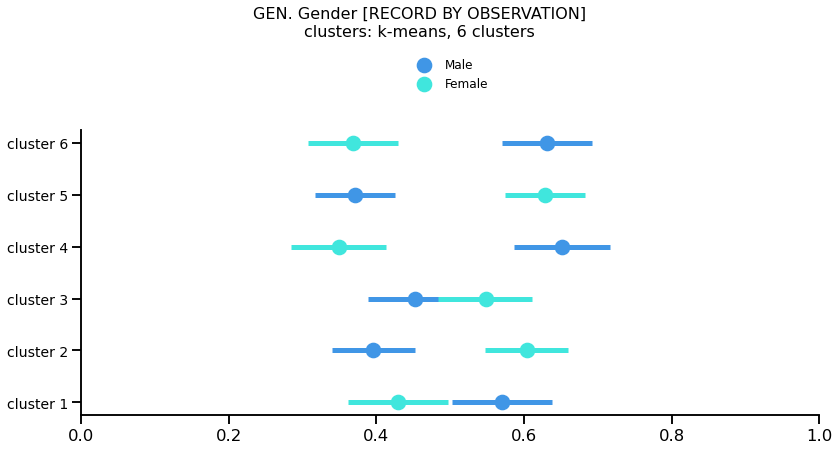

In [76]:
bivar_ci(data, 'weight', demo_feats[0], 'kmeans_6', response_dict, wording_dict)

In [92]:
#del response_dict['eduusa'][98.0]
#functions.bivar_bar(data, 'weight', 'eduusa', 'kmeans_6', response_dict, wording_dict)

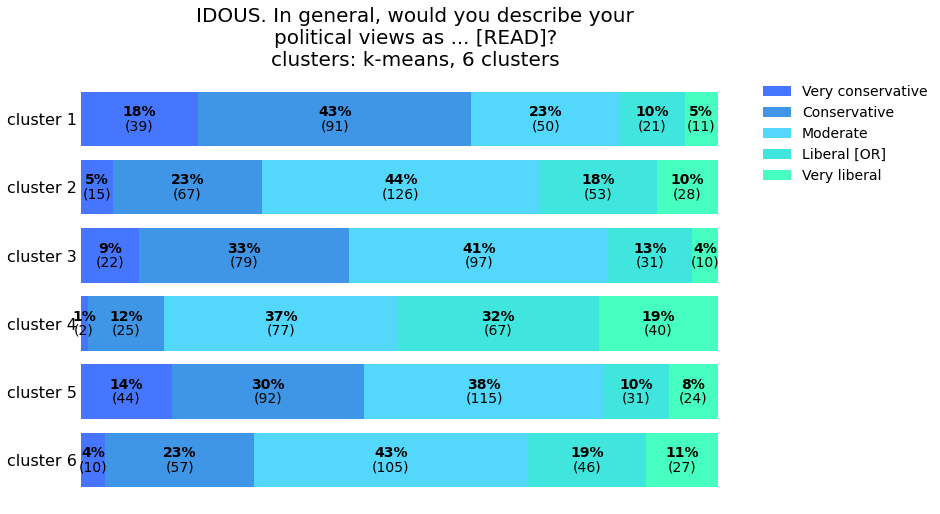

In [20]:
functions.bivar_bar(data, 'weight', demo_feats[3], 'kmeans_6', response_dict, wording_dict)

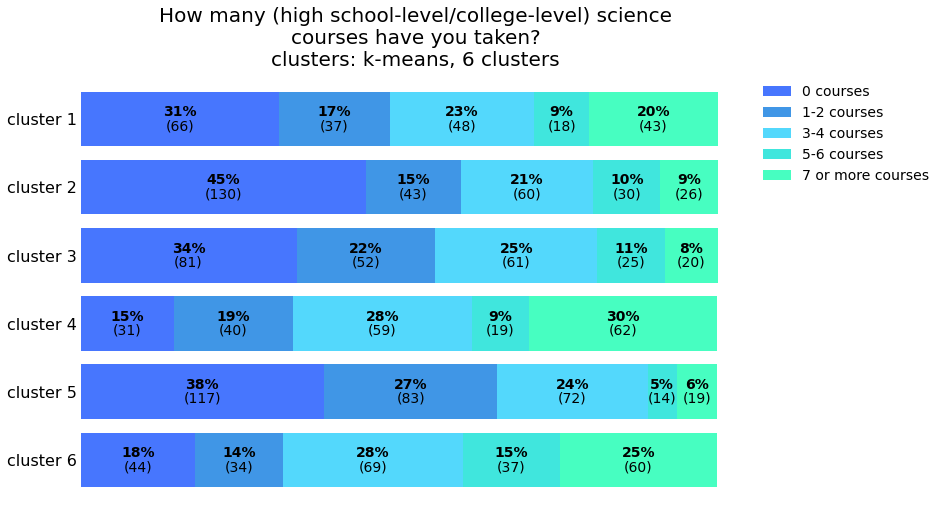

In [32]:
response_dict['sc_count'] = dict(sorted(response_dict['sc_count'].items()))
functions.bivar_bar(data, 'weight', demo_feats[5], 'kmeans_6', response_dict, wording_dict)

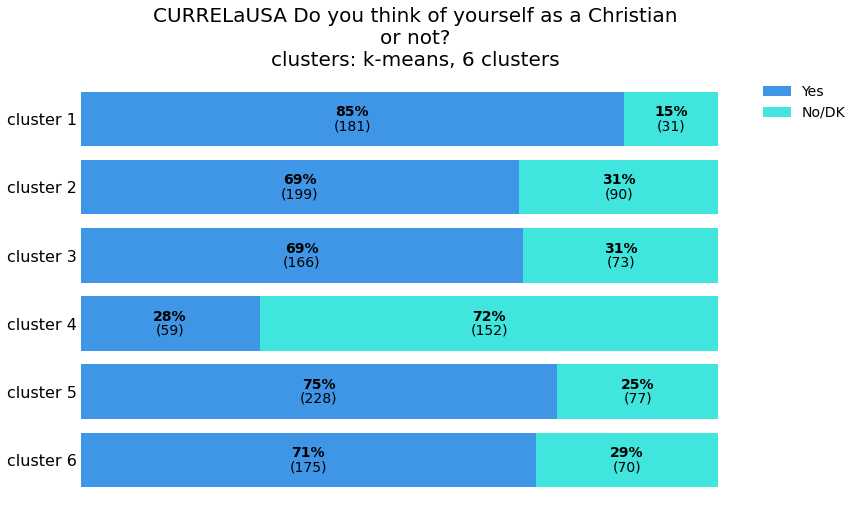

In [34]:
functions.bivar_bar(data, 'weight', demo_feats[6], 'kmeans_6', response_dict, wording_dict)

In [40]:
data['attend_rec'].value_counts()

 0.935675    339
-0.848562    264
-0.253816    262
-1.443307    260
 0.340929    192
 1.530420    185
Name: attend_rec, dtype: int64

In [94]:
response_dict['ATTEND']

{1.0: 'More than once a week',
 2.0: 'Once a week',
 3.0: 'Once or twice a month',
 4.0: 'A few times a year',
 5.0: 'Seldom',
 6.0: 'Never',
 97.0: 'Muslim (should not have received question)',
 98.0: 'Don’t know (DO NOT READ)',
 99.0: 'DK/Refused'}

In [95]:
del response_dict['ATTEND'][97.0]
del response_dict['ATTEND'][98.0]
functions.bivar_bar(data, 'weight', 'ATTEND', 'kmeans_6', response_dict, wording_dict)

# Multinomial Classification

In [26]:
X = data[q_factor_cols + demo_feats + ['weight']]
y = data['kmeans_6']

In [27]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1276, 32), (226, 32), (1276,), (226,))

In [28]:
w_train = X_train['weight']
w_test = X_test['weight']

In [29]:
X_train.drop(columns = 'weight', inplace = True)
X_test.drop(columns = 'weight', inplace = True)

In [84]:
# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, include_bias=False)
# Fit and transform our X data.
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)
features = poly.get_feature_names_out(input_features = X.columns[:-1])

In [30]:
# instantiate model
logreg = LogisticRegression(multi_class = 'multinomial', random_state = 42, max_iter = 10000)

## Ridge

In [31]:
ridge_params = {'penalty': ['l2'],
                'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                'C': [0.01, 0.1, 0.5, 1.0]}

# Instantiate GridSearchCV object.
ridge_grid = GridSearchCV(logreg, ridge_params, cv = 3)

# fit model
ridge_grid.fit(X_train, y_train, sample_weight = w_train)

/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jillmizell/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C a

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=10000,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0], 'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

In [32]:
ridge_grid.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [33]:
ridge_grid.best_score_

0.4004547546718218

In [34]:
ridge_grid.best_estimator_.coef_[0]

array([-0.34584961,  0.13866844, -0.10230638,  0.06919478, -0.07893744,
       -0.05256968,  0.10985022,  0.04274018, -0.07044358, -0.04624387,
        0.07248241,  0.06471856, -0.08082193, -0.02829324,  0.02819692,
        0.05830388,  0.07741428,  0.01589446, -0.04772324,  0.1482914 ,
        0.12830686,  0.05099989,  0.03214051, -0.07927646, -0.12681661,
       -0.02091144, -0.04693599,  0.07233789, -0.0537844 ,  0.01576494,
       -0.01971002])

In [36]:
features = list(X_test.columns)

In [37]:
clust_1_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[0]), 
                            columns = ['feature', 'Cluster_1_coef']).sort_values(by = 'Cluster_1_coef', 
                                                                                 key = np.abs, ascending = False)
clust_2_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[1]), 
                            columns = ['feature', 'Cluster_2_coef']).sort_values(by = 'Cluster_2_coef', 
                                                                                 key = np.abs, ascending = False)
clust_3_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[2]), 
                            columns = ['feature', 'Cluster_3_coef']).sort_values(by = 'Cluster_3_coef', 
                                                                                 key = np.abs, ascending = False)
clust_4_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[3]), 
                            columns = ['feature', 'Cluster_4_coef']).sort_values(by = 'Cluster_4_coef', 
                                                                                 key = np.abs, ascending = False)
clust_5_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[4]), 
                            columns = ['feature', 'Cluster_5_coef']).sort_values(by = 'Cluster_5_coef', 
                                                                                 key = np.abs, ascending = False)
clust_6_coef = pd.DataFrame(zip(features, ridge_grid.best_estimator_.coef_[5]), 
                            columns = ['feature', 'Cluster_6_coef']).sort_values(by = 'Cluster_6_coef', 
                                                                                 key = np.abs, ascending = False)

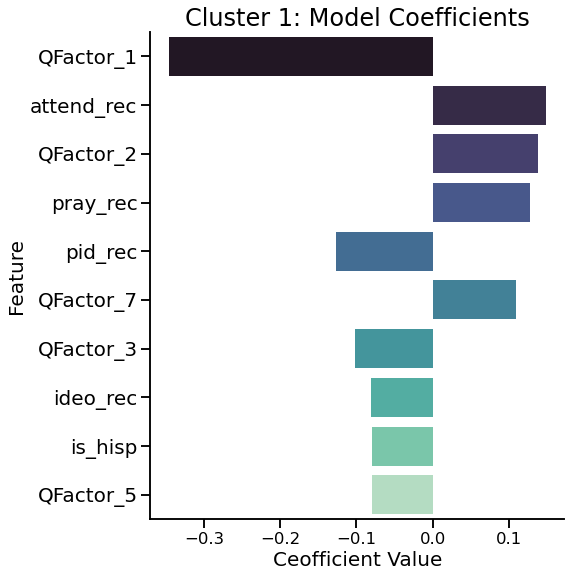

In [38]:
sns.catplot(y = 'feature', x = 'Cluster_1_coef', data = clust_1_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 1: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster1_coef.png", dpi = 300, bbox_inches = 'tight');

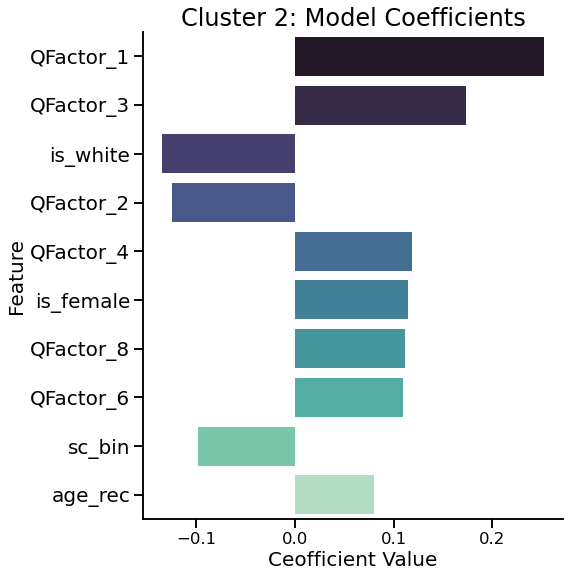

In [39]:
sns.catplot(y = 'feature', x = 'Cluster_2_coef', data = clust_2_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 2: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster2_coef.png", dpi = 300, bbox_inches = 'tight');

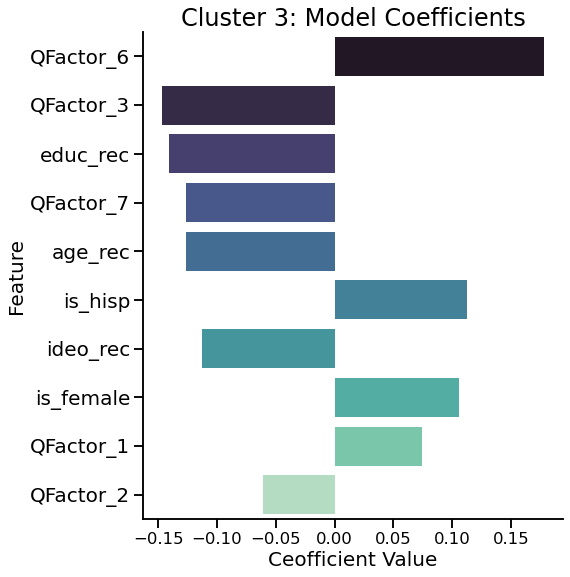

In [40]:
sns.catplot(y = 'feature', x = 'Cluster_3_coef', data = clust_3_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 3: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster3_coef.png", dpi = 300, bbox_inches = 'tight');

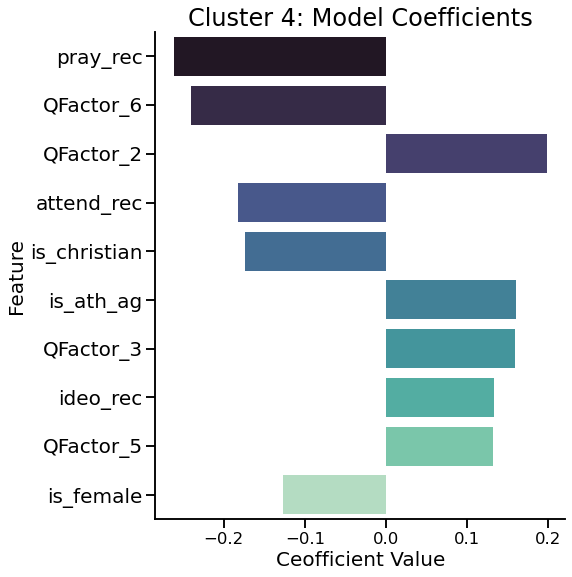

In [41]:
sns.catplot(y = 'feature', x = 'Cluster_4_coef', data = clust_4_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 4: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster4_coef.png", dpi = 300, bbox_inches = 'tight');

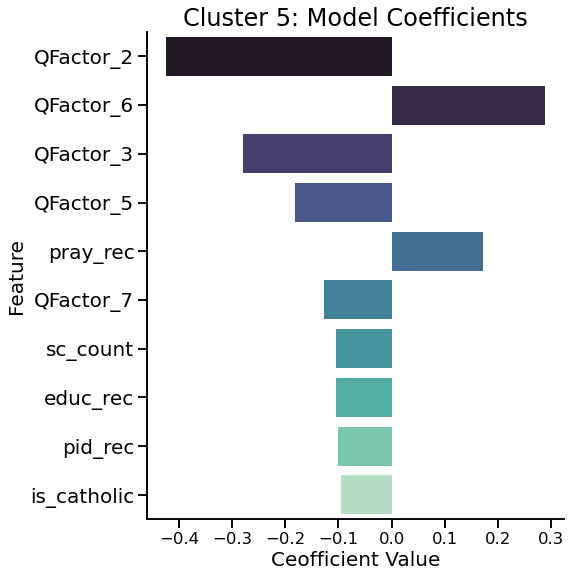

In [42]:
sns.catplot(y = 'feature', x = 'Cluster_5_coef', data = clust_5_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 5: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster5_coef.png", dpi = 300, bbox_inches = 'tight');

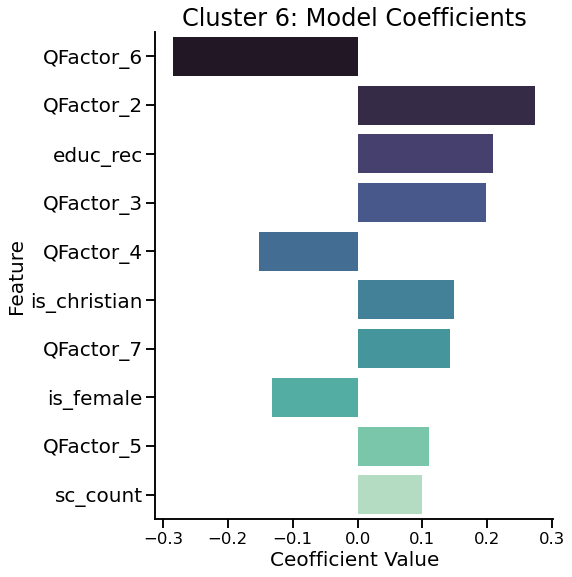

In [43]:
sns.catplot(y = 'feature', x = 'Cluster_6_coef', data = clust_6_coef.head(10), 
            kind = 'bar', ci = None,
            palette = 'mako',
            height = 8)

plt.title('Cluster 6: Model Coefficients', fontsize = 24)
plt.ylabel("Feature", fontsize = 20)
plt.xlabel("Ceofficient Value", fontsize = 20)
plt.yticks(fontsize = 20)
sns.despine()
plt.savefig("../images/cluster6_coef.png", dpi = 300, bbox_inches = 'tight');

In [44]:
ridge_mod = LogisticRegression(multi_class = 'multinomial', random_state = 42, 
                               C = 0.01, penalty = 'l2', solver = 'newton-cg')
ridge_mod.fit(X_train, y_train, sample_weight = w_train)

LogisticRegression(C=0.01, multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [45]:
ridge_mod.score(X_test, y_test, sample_weight = w_test)

0.4028518643111577